In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.metrics import precision_score, recall_score,accuracy_score



In [2]:
# !pip install surprise
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install numpy


In [3]:
!pip install gradio

In [4]:
data=pd.read_csv("../Dataset/FactInternetSales.csv")
data.head()

,ProductKey,OrderDateKey,OnlineCustomerID,CustomerID,SalesTerritoryKey,SalesOrderNumber,SalesOrderLineNumber,LineTotal,OrderQuantity,UnitPrice,UnitPriceDiscount,SubTotal,TaxAmt,Freight,TotalDue,OrderDate,DueDate,ShipDate,ModifiedDate
0,776,20050701,1045,29825,5,43659,1,2024.99,1,2024.994,0.0,20565.6206,1971.5149,616.0984,23153.23,2005-07-01 00:00:00,2005-07-13 00:00:00,2005-07-08 00:00:00,2005-07-08 00:00:00
1,777,20050701,1045,29825,5,43659,2,6074.98,3,2024.994,0.0,20565.6206,1971.5149,616.0984,23153.23,2005-07-01 00:00:00,2005-07-13 00:00:00,2005-07-08 00:00:00,2005-07-08 00:00:00
2,778,20050701,1045,29825,5,43659,3,2024.99,1,2024.994,0.0,20565.6206,1971.5149,616.0984,23153.23,2005-07-01 00:00:00,2005-07-13 00:00:00,2005-07-08 00:00:00,2005-07-08 00:00:00
3,771,20050701,1045,29825,5,43659,4,2039.99,1,2039.994,0.0,20565.6206,1971.5149,616.0984,23153.23,2005-07-01 00:00:00,2005-07-13 00:00:00,2005-07-08 00:00:00,2005-07-08 00:00:00
4,772,20050701,1045,29825,5,43659,5,2039.99,1,2039.994,0.0,20565.6206,1971.5149,616.0984,23153.23,2005-07-01 00:00:00,2005-07-13 00:00:00,2005-07-08 00:00:00,2005-07-08 00:00:00


In [5]:
# Drop rows with missing CustomerKey, OrderDate, or SalesAmount
data = data.dropna(subset=['CustomerID', 'OrderDate', 'TotalDue'])

# Convert OrderDate to datetime if necessary
data['OrderDate'] = pd.to_datetime(data['OrderDate'])

# Preview the cleaned data
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ProductKey            121317 non-null  int64         
 1   OrderDateKey          121317 non-null  int64         
 2   OnlineCustomerID      121317 non-null  int64         
 3   CustomerID            121317 non-null  int64         
 4   SalesTerritoryKey     121317 non-null  int64         
 5   SalesOrderNumber      121317 non-null  int64         
 6   SalesOrderLineNumber  121317 non-null  int64         
 7   LineTotal             121317 non-null  float64       
 8   OrderQuantity         121317 non-null  int64         
 9   UnitPrice             121317 non-null  float64       
 10  UnitPriceDiscount     121317 non-null  float64       
 11  SubTotal              121317 non-null  float64       
 12  TaxAmt                121317 non-null  float64       
 13 

In [6]:
import datetime
current_date = data['OrderDate'].max()
year = current_date.year
today =datetime.date(year, 12, 31)
today=pd.to_datetime(today)

# current_date = pd.to_datetime('2008-12-31')

#Aggregate Features
rfm = data.groupby('CustomerID').agg({
    'OrderDate': lambda x: (today - x.max()).days,  # Recency
    'TotalDue': ['count', 'sum']  # Frequency and Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
temp=rfm.copy()
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,11000,423,8,22784.02
1,11001,202,11,22376.68
2,11002,492,4,11639.06
3,11003,416,9,24704.66
4,11004,425,6,16982.72


In [7]:
from sklearn.preprocessing import StandardScaler

# Scale the RFM data: Models (use ditance between two points) Converge faster when the data is scaled.
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

rfm_scaled[:5]


array([[ 0.53006709,  0.06249159, -0.0799505 ],
       [-0.93915564,  0.17579426, -0.08020043],
       [ 0.98878369, -0.08857864, -0.08678849],
       [ 0.48353062,  0.10025915, -0.0787721 ],
       [ 0.54336322, -0.01304353, -0.08350989]])

In [8]:
from sklearn.cluster import KMeans

# Choose an optimal number of clusters, here we start with 4
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters, random_state=7200)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)
rfm.head()

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,CustomerID,Recency,Frequency,Monetary,Segment
0,11000,423,8,22784.02,0
1,11001,202,11,22376.68,2
2,11002,492,4,11639.06,0
3,11003,416,9,24704.66,0
4,11004,425,6,16982.72,0


In [9]:
mean_segments = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean()
mean_segments.head(n_clusters) # there are only four segments as we assigned before
    # Segment 2: Formerly active but now disengaged customers.
    # Segment 1: The most valuable, loyal customers.
    # Segment 0: Less engaged, infrequent buyers with lower revenue contributions.


,Recency,Frequency,Monetary
Segment,,,
0,490.305236,3.446666,2.759568e+04
1,281.492754,279.021739,1.677162e+07
2,263.688630,4.863088,3.481940e+04


In [10]:
#Measures how similar an object is to its own cluster compared to other clusters. A higher score indicates better-defined clusters.
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(rfm_scaled, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.5507067901388597


In [11]:
#Measures the average similarity ratio of each cluster with the cluster that is most similar to it. Lower values indicate better clustering.
from sklearn.metrics import davies_bouldin_score
db_score = davies_bouldin_score(rfm_scaled, kmeans.labels_)
print("Davies-Bouldin Index:", db_score)


Davies-Bouldin Index: 0.5859501755261195


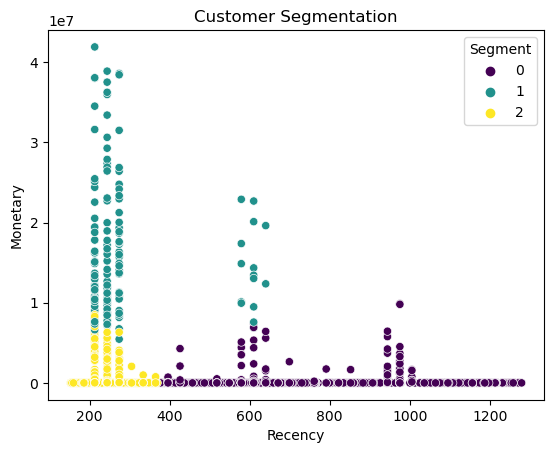

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the segments
sns.scatterplot(x='Recency', y='Monetary', hue='Segment', data=rfm, palette='viridis')
plt.title('Customer Segmentation')
plt.show()

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

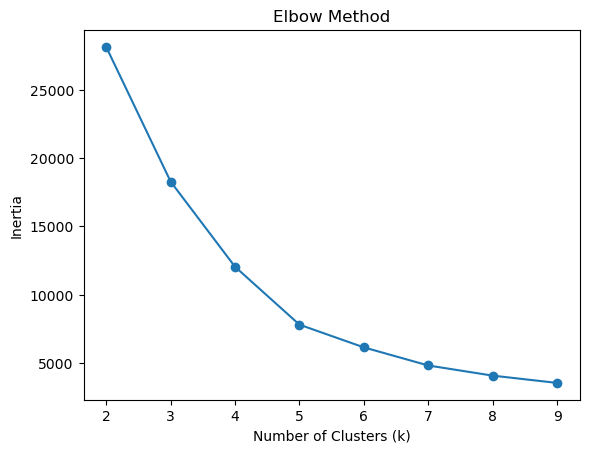

In [13]:
#Inertia (Within-Cluster Sum of Squares): Measures how tightly the clusters are packed. Lower inertia indicates better clustering.
#-- how closely the data points in a cluster are to the cluster centroid.
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method') #the graph looks like an elbow
plt.show()


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

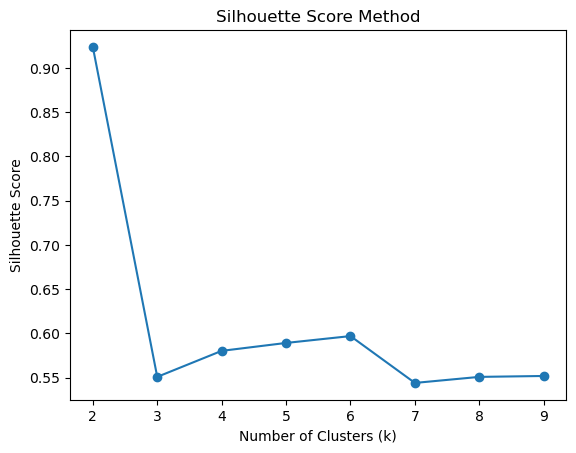

In [14]:
#Measures how similar an object is to its own cluster compared to other clusters. A higher score indicates better-defined clusters.

from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)


plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

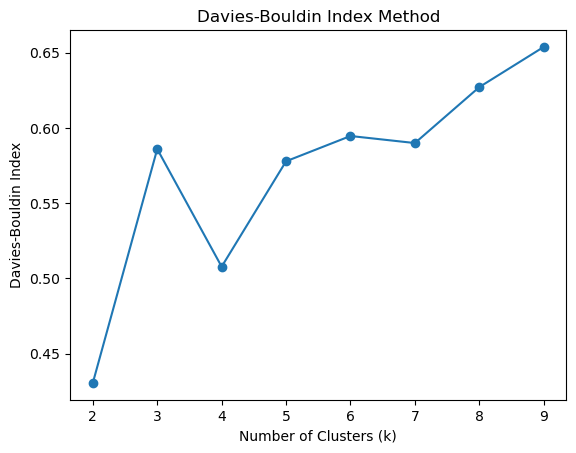

In [15]:
#Measures the average similarity ratio of each cluster with the cluster that is most similar to it. Lower values indicate better clustering.

from sklearn.metrics import davies_bouldin_score

db_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    score = davies_bouldin_score(rfm_scaled, kmeans.labels_)
    db_scores.append(score)

plt.plot(k_values, db_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index Method')
plt.show()


In [16]:
import pickle
# Save the model to a file
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)


In [17]:
import gradio as gr
import pandas as pd
import pickle

# Load the trained model
with open('kmeans_model.pkl', 'rb') as f:
    kmeans = pickle.load(f)

# Example customer data DataFrame (for prediction)
#CustomerIDs example: 30113 23941 19817 14761
customer_data=temp.copy()
# customer_data = {
#     'CustomerID': [1, 2, 3, 4],
#     'Recency': [10, 20, 30, 40],
#     'Frequency': [5, 10, 2, 4],
#     'Monetary': [100, 150, 50, 80]
# }

df = pd.DataFrame(customer_data)

def segment_customer(customer_id):
    # Convert customer_id to integer
    try:
        customer_id = int(customer_id)
    except ValueError:
        return "Invalid Customer ID. Please enter a valid integer."

    # Fetch customer data based on ID
    customer = df[df['CustomerID'] == customer_id]

    # Check if the customer exists
    if customer.empty:
        return "Customer ID not found."

    # Extract features for prediction row
    features = customer[['Recency', 'Frequency', 'Monetary']].values

    # Predict the segment
    segment = kmeans.predict(features)

    # Segment 2: Formerly active but now disengaged customers: May Churned.
    # Segment 1: The most valuable, loyal customer: Loyal Customers
    # Segment 0: Less engaged, infrequent buyers with lower revenue contributions:Occasional Buyers
    x=""
    if segment[0] == 0:
        x="Occasional Buyers"
    elif segment[0] == 1:
        x="Loyal Customers"
    else:
        x="May Churn"
    return f"Customer {customer_id} is in the {x} Segment"

iface_segmentation = gr.Interface(
    fn=segment_customer,
    inputs=gr.Textbox(label="Customer ID"),  # Input component
    outputs=gr.Label(),  # Output component
    title="Customer Segmentation",
    description="Enter Customer ID to get the customer segment."
)

iface_segmentation.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [18]:
temp.to_csv('customers_Segs.csv', index=False)

In [19]:
%%writefile app.py
import streamlit as st
import pandas as pd
import pickle

# Load the trained KMeans model
with open('kmeans_model.pkl', 'rb') as f:
    kmeans = pickle.load(f)

# Load customer data from CSV
df = pd.read_csv('Customer_Seg.csv')

# Function to segment customer
def segment_customer(customer_id):
    # Convert customer_id to integer
    try:
        customer_id = int(customer_id)
    except ValueError:
        return "Invalid Customer ID. Please enter a valid integer."

    # Fetch customer data based on ID
    customer = df[df['CustomerID'] == customer_id]

    # Check if the customer exists
    if customer.empty:
        return "Customer ID not found."

    # Extract features for prediction row
    features = customer[['Recency', 'Frequency', 'Monetary']].values

    # Predict the segment
    segment = kmeans.predict(features)

    # Segment descriptions
    if segment[0] == 0:
        return f"Customer {customer_id} is in the Occasional Buyers Segment"
    elif segment[0] == 1:
        return f"Customer {customer_id} is in the Loyal Customers Segment"
    else:
        return f"Customer {customer_id} is in the May Churn Segment"

# Streamlit App
st.title("Customer Segmentation")

# Input for customer ID
customer_id = st.text_input("Customer ID", "")  # Text input for Customer ID

# Button to get the segment
if st.button("Get Segment"):
    # Call the function and display the result
    result = segment_customer(customer_id)
    st.write(result)


Overwriting app.py


In [20]:
!wget -q -O - ipv4.icanhazip.com

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [21]:
!streamlit run app.py & npx localtunnel --port 850

^C
